# Visualization tests

In [1]:
from py2neo import Graph

In [2]:
graph = Graph("neo4j://localhost:7687", auth=("neo4j", "neo4j"))

In [3]:
import neo4jupyter as n4j
n4j.init_notebook_mode()
#sg = graph.run('MATCH (m:Movie) RETURN m.name')
#n4j.draw(graph, {'Movie':'name'})

<IPython.core.display.Javascript object>

drawGraph() is based on draw() function from the package [neo4jupyter](https://github.com/merqurio/neo4jupyter) just passing the query as a parameter to run it on the graph and visualize the result.

In [4]:
import neo4jupyter as n4j
n4j.init_notebook_mode()
# Based on function draw() from neo4jupyter (https://github.com/merqurio/neo4jupyter)
def drawGraph(graph, options, query, physics=True):
    """
    The options argument should be a dictionary of node labels and property keys; it determines which property
    is displayed for the node label. For example, in the movie graph, options = {"Movie": "title", "Person": "name"}.
    Omitting a node label from the options dict will leave the node unlabeled in the visualization.
    Setting physics = True makes the nodes bounce around when you touch them!
    :param graph: Connection to the DB where the query will be executed.
    :param options: Options for the Nodes.
    :param physics: Physics of the vis.js visualization.
    :param limit: Maximum number of Nodes or Edges.
    :return: IPython.display.HTML
    """

#     query = """
#     MATCH (n)
#     WITH n, rand() AS random
#     ORDER BY random
#     LIMIT $limit
#     OPTIONAL MATCH (n)-[r]->(m)
#     RETURN n AS source_node,
#            id(n) AS source_id,
#            r,
#            m AS target_node,
#            id(m) AS target_id
#     """

    data = graph.run(query)#, limit=limit)

    nodes = []
    edges = []

    def get_vis_info(node, id):
        node_label = list(node.labels)[0]
        prop_key = options.get(node_label)
        vis_label = node.get(prop_key, "")

        return {"id": id, "label": vis_label, "group": node_label, "title": repr(node)}

    for row in data:
        source_node = row[0]
        source_id = row[1]
        rel = row[2]
        target_node = row[3]
        target_id = row[4]

        source_info = get_vis_info(source_node, source_id)

        if source_info not in nodes:
            nodes.append(source_info)

        if rel is not None:
            target_info = get_vis_info(target_node, target_id)

            if target_info not in nodes:
                nodes.append(target_info)

            edges.append({"from": source_info["id"], "to": target_info["id"], "label": rel.__class__.__name__})

    return n4j.vis_network(nodes, edges, physics=physics)



<IPython.core.display.Javascript object>

In [5]:
query = """
    MATCH (p:Person)-[r:APPEARS_IN]->(m:Movie)
    WHERE m.name='Episode I: The Phantom Menace'
    RETURN m AS source_node,
           id(m) AS source_id,
           r,
           p AS target_node,
           id(p) AS target_id
    LIMIT 10
    """
drawGraph(graph, {'Movie':'name', 'Person':'name'}, query)

In [21]:
query = """
    MATCH (m:Movie)
    RETURN m AS source_node,
           id(m) AS source_id,
           Null,
           Null AS target_node,
           Null AS target_id
"""
drawGraph(graph, {'Movie':'name'}, query)

In [163]:
query = """
    MATCH (p:Person)-[r:SPEAKS_WITH]->(d:Droid)
    OPTIONAL MATCH (n)-[r]->(m)
    RETURN n AS source_node,
           id(n) AS source_id,
           r,
           m AS target_node,
           id(m) AS target_id
    LIMIT 100
"""           
drawGraph(graph, {'Movie':'name','Person':'name','Droid':'name'}, query)

In [7]:
from neo4j import GraphDatabase, basic_auth

In [8]:
uri = "bolt://localhost:7687"
user = "neo4j"
password = "neo4j"

driver = GraphDatabase.driver(uri, auth=basic_auth(user, password))
session = driver.session(database="neo4j")

In [ ]:
 #pip install git+https://github.com/ybaktir/networkx-neo4j

Testing with package [nxneo4j](https://github.com/ybaktir/networkx-neo4j), that provides networkx functions to use in neo4j. One of that functions is draw, which prints the nodes and connections of the graph.

In [9]:
import nxneo4j as nx

In [10]:
config = {
    "node_label": None,
    "relationship_type": None,
    "identifier_property": 'name'
}

In [11]:
'''Same problem as neo4jupyter it draws the whole database graph, because you pass the driver for conection
     as parameter, and inside function draw() it makes a query that returns all the nodes and connections.
'''
G = nx.DiGraph(driver, config)
nx.draw(G)

This is a solution I found in [this Stack Overflow question](https://stackoverflow.com/questions/59289134/constructing-networkx-graph-from-neo4j-query-result#:~:text=Here%20is%20a%20more%20compact%20code%3A). It uses networkx to draw the graph and the logic is basically transforming a query to our database into a MultiDiGraph object, which can be read by the function draw().

In [26]:
# Maybe we could change a little bit this code in order to show also the names of the nodes and edges
from neo4j import GraphDatabase
import networkx as nx

driver = GraphDatabase.driver('bolt://localhost:7687', auth=("neo4j", "neo4j"))

query = """
    MATCH p=()-[:APPEARS_IN]->(m)
    WHERE m.name='Episode I: The Phantom Menace'
    RETURN p
"""

results = driver.session().run(query)

G = nx.MultiDiGraph()

nodes = list(results.graph()._nodes.values())
for node in nodes:
    G.add_node(node.id, labels=node._labels, properties=node._properties)

rels = list(results.graph()._relationships.values())
for rel in rels:
    G.add_edge(rel.start_node.id, rel.end_node.id, key=rel.id, type=rel.type, properties=rel._properties)

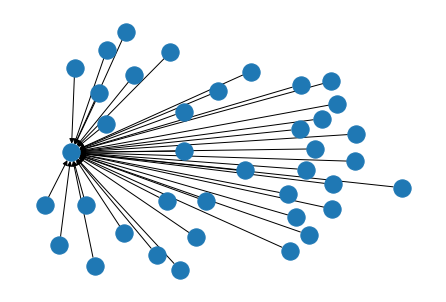

In [27]:
nx.draw(G)

In [28]:
#Close all connections
driver.close()
session.close()
drive = None
session = None